<style>
.header {
    background: linear-gradient(90deg, #071124 0%, #0b5261 50%, #2fb5b0 100%);
    color: #ffffff;
    padding: 20px 26px;
    border-radius: 12px;
    text-align: center;
    box-shadow: 0 6px 18px rgba(11, 37, 60, 0.45);
    margin-bottom: 16px;
    font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial;
}
.header h1 {
    margin: 0;
    font-size: 1.8rem;
    letter-spacing: -0.5px;
}
.header p {
    margin: 6px 0 0;
    color: rgba(255,255,255,0.92);
    font-size: 0.96rem;
    text-align: center;
    display: block;
    max-width: 800px;
    margin-left: auto;
    margin-right: auto;
    background: rgba(255,255,255,0.04);
    padding: 8px 12px;
    border-radius: 10px;
}
.badges {
    margin-top: 10px;
}
.badge {
    display: inline-block;
    background: rgba(255,255,255,0.12);
    color: #e6f7f7;
    padding: 6px 10px;
    border-radius: 999px;
    font-size: 0.78rem;
    margin: 0 6px;
}
.kv {
    margin-top: 12px;
    text-align: left;
    max-width: 900px;
}
.kv dt { font-weight: 600; }
.kv dd { margin: 4px 0 10px 0; color: #333; }

.header h2 {
    font-size: 1.05rem; /* smaller than h1 (1.8rem) */
    margin: 6px 0 0;
    font-weight: 500;
    color: rgba(255,255,255,0.95);
}
</style>

<div class="header">
    <h1>Implied volatility surface</h1>
    <h2>A first attempt</h2>
    <p>Extract the rough implied volatility surface from market data.</p>
    <div class="badges">
        <span class="badge">Option</span>
        <span class="badge">Implied Volatility</span>
        <span class="badge">Python</span>
    </div>
</div>

---

### Overview
- Goal: extract and analyze the implied volatility surface from option market data.
- Approach: gather option prices → compute implied volatilities → visualize and interpret the surface.

### Quick reference
- Instruments: options on equities
- Data source: market data providers (e.g., Bloomberg, Yahoo Finance)

---

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

# Black/Scholes formula

In order to retrieve the implied volatility from market option prices, we first need to implement the Black/Scholes formula for European call options and put options. The Black/Scholes price of a European call option expiring at time $T$ with strike price $K$ is

$$
C(S,t)=SN(d_1)−Ke^{−r(T−t)}N(d_2)\\

P(S,t)=Ke^{−r(T−t)}N(−d_2)−SN(−d_1)
$$

where $S$ is the current price of the underlying asset, $t$ the current time and $r$ the continuously compounded riskfree interest rate. $N(d)$ denotes the cumulative distribution function of the standard normal distribution, and

$$

d_1 = \frac{\ln\frac{S}K+(r+\frac12\sigma^2)(T−t)}{\sigma\sqrt{T-t}}\\
d_2 = d_1−\sigma\sqrt{T-t}


$$

where the $\sigma$ denotes the volatility of the underlying asset


In [2]:
def BlackScholes(S, K, sgm, r, T, callput):
    d1 = (np.log(S / K) + (r + (sgm**2) / 2) * T) / (sgm * np.sqrt(T))
    d2 = d1 - sgm * np.sqrt(T)
    if callput == 1:
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied volatility

To calculate the price of a European option, we need to know whether it is a call or a put, the strike $K$, and its time to expiry - these are properties specified in the option contract. Furthermore, we need to know the current price of the underlying asset $(S)$ and the interest rate $r$ - these are things which can arguably be observed in the market. Lastly, we need the volatility $\sigma$ - this is not directly observable in the market. Although it can be statistically estimated, when prices for actively traded options are available in the market, the preferred method to obtain sigma is to **imply** it from those market prices. This is the <B><I>implied volatility</I></B>, i.e. the $\sigma$ which needs to be inserted into the Black/Scholes formula so that, in combination with the observed values for the other input variables, it returns the observed market price of the option.

Implied volatility cannot be obtained by algebraically solving the Black/Scholes formula for volatility - this is not analytically possible. Therefore, Black/Scholes implied volatility must be obtained numerically using a _root search._ The SciPy package provides a root search routine for Python, which for a user-defined function finds the function argument which results in a zero function value.


In [3]:
def BlackScholesImpVol(S, K, r, T, callput, price):
    def Vol_Searcher(sgm, S, K, r, T, callput, price):
        return price - BlackScholes(S, K, sgm, r, T, callput)

    return root_scalar(
        Vol_Searcher, bracket=[-1000, 1000], args=(S, K, r, T, callput, price)
    ).root

# Plotting an implied volatility smile from option price data

**Data**: Options on Tesla, Inc. (TSLA)

**Date**: 8 March 2023

**Price of TSLA**: USD 182.00

**Options**: American style, non-dividend paying => can be priced as European

**Risk-free rate**: 5.751038% continuously compounded for maturity 15 March 2024

**Daycount convention**: ACT/365

**Price of option**: Midpoint of bid-ask spread


In [4]:
S = 182
r = 0.05751038
t = pd.to_datetime("2023-03-08")

df = pd.read_excel("TSLA.xlsx")
df["Expiration Date"] = pd.to_datetime(df["Expiration Date"], format="%a %b %d %Y")
df["Call Price"] = (df["Bid"] + df["Ask"]) / 2
df["Put Price"] = (df["Bid.1"] + df["Ask.1"]) / 2
df["Call Volume"] = df["Volume"]
df["Put Volume"] = df["Volume.1"]
df = df[
    [
        "Expiration Date",
        "Strike",
        "Call Price",
        "Put Price",
        "Call Volume",
        "Put Volume",
    ]
]
df["Time to Expiry"] = (df["Expiration Date"] - t).dt.days / 365
df["Implied Vol Call"] = df.apply(
    lambda row: BlackScholesImpVol(
        S, row["Strike"], r, row["Time to Expiry"], 1, row["Call Price"]
    ),
    axis=1,
)
df["Implied Vol Put"] = df.apply(
    lambda row: BlackScholesImpVol(
        S, row["Strike"], r, row["Time to Expiry"], -1, row["Put Price"]
    ),
    axis=1,
)
display(df)

,Expiration Date,Strike,Call Price,Put Price,Call Volume,Put Volume,Time to Expiry,Implied Vol Call,Implied Vol Put
0,2023-03-10,50.0,132.050,0.005,0,1,0.005479,6.262016,5.316893
1,2023-03-10,80.0,102.050,0.005,1,0,0.005479,3.939047,3.436451
2,2023-03-10,90.0,92.075,0.005,1,0,0.005479,3.630504,2.965551
3,2023-03-10,95.0,87.075,0.005,0,1,0.005479,3.358091,2.749046
4,2023-03-10,110.0,72.100,0.005,1,2,0.005479,2.766580,2.159898
...,...,...,...,...,...,...,...,...,...
1765,2025-06-20,380.0,23.450,200.725,1,1,2.287671,0.519386,0.761599
1766,2025-06-20,390.0,22.475,210.100,77,0,2.287671,0.520080,0.777768
1767,2025-06-20,400.0,21.400,219.575,149,0,2.287671,0.519229,0.794462
1768,2025-06-20,410.0,20.650,229.025,153,0,2.287671,0.521128,0.810568


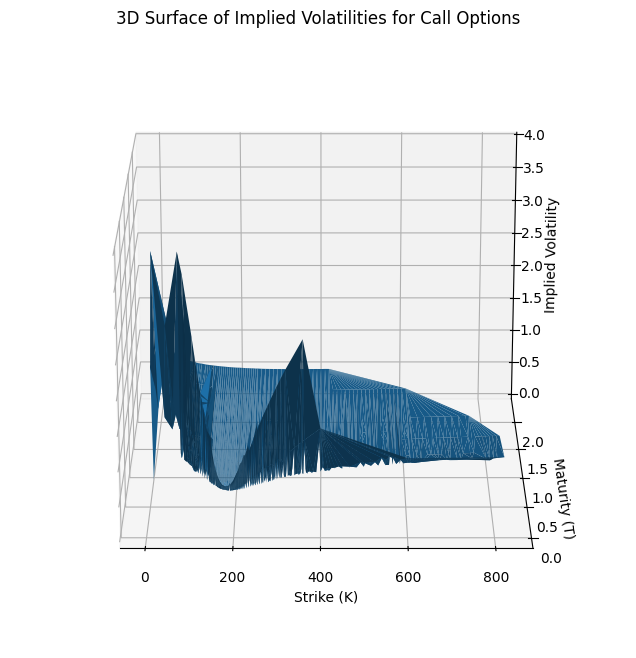

In [20]:
# Plot 3d surface of implied volatilities
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(
    df[df["Call Volume"] > 0]["Strike"],
    df[df["Call Volume"] > 0]["Time to Expiry"],
    df[df["Call Volume"] > 0]["Implied Vol Call"],
)
ax.set_xlabel("Strike (K)")
ax.set_ylabel("Maturity (T)")
ax.set_zlabel("Implied Volatility")
ax.set_title("3D Surface of Implied Volatilities for Call Options")
ax.view_init(elev=20, azim=-90)

plt.show()

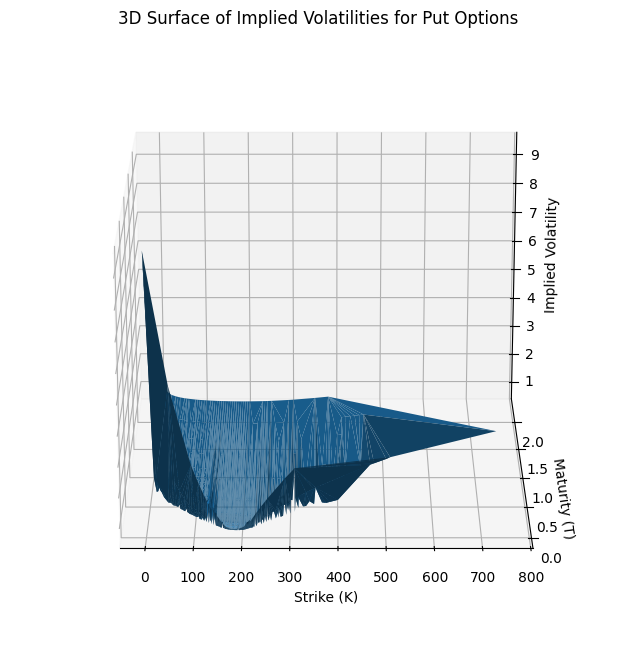

In [19]:
# Plot 3d surface of implied volatilities
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(
    df[df["Put Volume"] > 0]["Strike"],
    df[df["Put Volume"] > 0]["Time to Expiry"],
    df[df["Put Volume"] > 0]["Implied Vol Put"],
)
ax.set_xlabel("Strike (K)")
ax.set_ylabel("Maturity (T)")
ax.set_zlabel("Implied Volatility")
ax.set_title("3D Surface of Implied Volatilities for Put Options")
ax.view_init(elev=20, azim=-90)

plt.show()

From the plot of the implied volatility surface for call options, we can observe several key features:
1. **Volatility Smile/Skew**: The surface exhibits a volatility smile at most maturities, where implied volatility tends to be higher for deep in-the-money and out-of-the-money options compared to at-the-money options. This indicates that market participants expect higher volatility for extreme price movements.
2. **Maturity Effect**: Implied volatility generally decreases with increasing time to expiry. This suggests that short-term options are perceived to be riskier, possibly due to upcoming events or market uncertainty.
3. **Market Sentiment**: The shape of the surface can reflect market sentiment and expectations about future volatility. For instance, if the surface is elevated for certain strikes or maturities, it may indicate that traders expect significant price movements in the underlying asset.

From the plot of the implied volatility surface for put options, we can observe several key features:
1. **Volatility Smile/Skew**: Similar to call options, the put option surface also shows a volatility smile, indicating that market participants expect higher volatility for extreme price movements in the underlying asset.
2. **Maturity Effect**: The implied volatility for put options also tends to decrease with increasing time to expiry, consistent with the observations for call options.

In general, both surfaces highlight the market's expectations of volatility and risk associated with the underlying asset, which can be crucial for traders and risk managers when making decisions. Yet, this is just a first attempt and more sophisticated methods could be employed to obtain a smoother and more accurate implied volatility surface.